In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

In [2]:
batch_size = 256
img_size = (32,32)
ds_train = tfds.load('mnist', split='train', shuffle_files=True)
ds_test = tfds.load('mnist', split='test', shuffle_files=True)

def rescale_img(x):
    img=x['image']
    label=x['label']
    img = tf.tile(img,(1,1,3))
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img, label


ds_train = ds_train.map(rescale_img).batch(batch_size).prefetch(batch_size)
ds_test = ds_test.map(rescale_img).batch(batch_size).prefetch(batch_size)

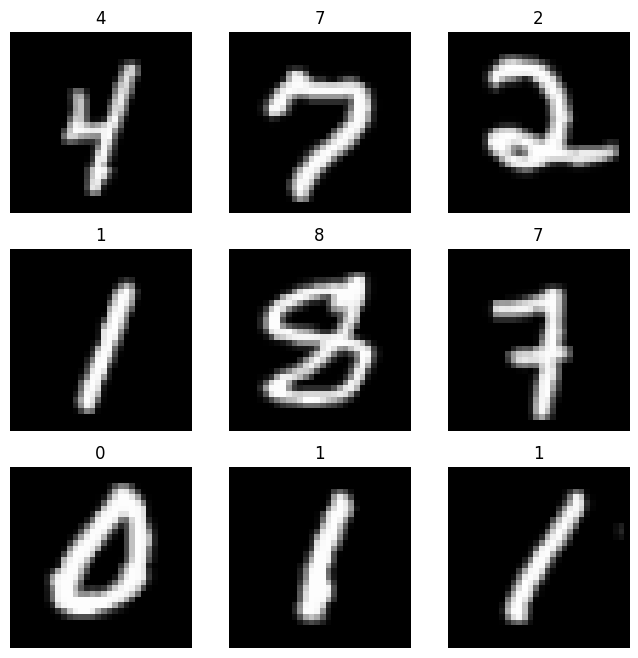

In [3]:
# visualize data
import matplotlib.pyplot as plt
sample = next(iter(ds_train))

fig, axes = plt.subplots(3,3, figsize=(8,8))
for i in range(9):
    axe = axes[i%3, i//3]
    img = sample[0][i]
    label = sample[1][i]
    axe.imshow(img)
    axe.set_title(label.numpy())
    axe.axis('off')

In [4]:
# generate tranformed dataset

def generate_transform(img,label):
    x_original, label = img, label
    img_size = tf.shape(x_original)
    val = tf.random.normal((img_size[0],)) / 3
    x_rotated = tfa.image.rotate(x_original, val)
    x_transform = tfa.image.translate(x_rotated, (0,0))
    return x_transform, label
    
ds_train_transform = ds_train.map(generate_transform)

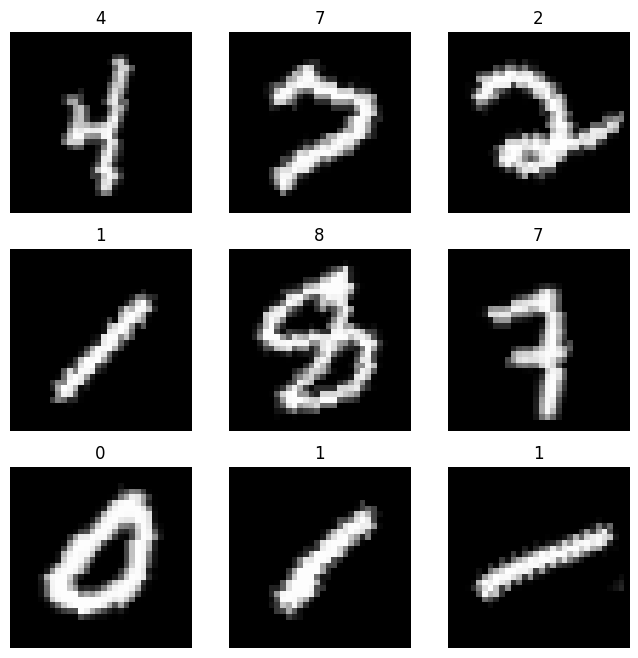

In [5]:
# visualize transformed data
sample = next(iter(ds_train_transform))
val = tf.constant([1,0,0,0,1,0,0,0], dtype=tf.float32)
img_trans = tfa.image.transform(sample[0],val)
fig, axes = plt.subplots(3,3, figsize=(8,8))
for i in range(9):
    axe = axes[i%3, i//3]
    x, label = sample
    axe.imshow(img_trans[i])
    axe.set_title(label[i].numpy())
    axe.axis('off')
# fig, axes = plt.subplots(3,3, figsize=(8,8))
# for i in range(9):
#     axe = axes[i%3, i//3]
#     x, (y, label, val) = sample
#     axe.imshow(y[i])
#     axe.set_title(label[i].numpy())
#     axe.axis('off')

# fig, axes = plt.subplots(3,3, figsize=(8,8))
# for i in range(9):
#     axe = axes[i%3, i//3]
#     x, (y, label, val) = sample
#     axe.imshow(x[i])
#     axe.set_title(f'{val[i].numpy():.2f}')
#     axe.axis('off')

In [6]:
# backbone = tf.keras.applications.EfficientNetB1(include_top=False)

import numpy as np 
sample = next(iter(ds_train_transform))

class stn(tf.Module):
    def __init__(self, name=None):
        super().__init__(name)

        self.backbone = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(10, kernel_size=5, activation='relu'),
                tf.keras.layers.Conv2D(20, kernel_size=5, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(50),
                tf.keras.layers.Dense(10),
            ]
        )

        self.localization = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(8, kernel_size=7),
                tf.keras.layers.MaxPool2D(2, strides=2),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(10, kernel_size=5),
                tf.keras.layers.MaxPool2D(2, strides=2),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(10*3*3*32),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Dense(3*2, kernel_initializer=tf.keras.initializers.Zeros(), bias_initializer = tf.keras.initializers.constant(([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]))),
            ]
        )
        # self.localization.layers[-1].set_weights()
    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''        
        shape = tf.shape(inputs)
        batch_size, height, width = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, height, width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def stn(self, img):
        theta = self.localization(img)
        theta = tf.reshape(theta, (-1, 2, 3))

        x_shape = tf.shape(img)
        x_space = tf.linspace(-1,1,x_shape[-3])
        y_space = tf.linspace(-1,1,x_shape[-2])

        xx, yy = tf.meshgrid(x_space, y_space)
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))
        homogeneous_coordinates = tf.stack([xx,yy,tf.ones_like(xx)])
        homogeneous_coordinates = tf.expand_dims(homogeneous_coordinates, axis=0)
        homogeneous_coordinates = tf.tile(homogeneous_coordinates, [x_shape[0], 1, 1])
        homogeneous_coordinates = tf.cast(homogeneous_coordinates, dtype = tf.float32)
        

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogeneous_coordinates)
            transformed = tf.transpose(transformed, perm=[0,2,1])
            transformed = tf.reshape(transformed, (-1, x_shape[1], x_shape[2], 2))

            x_transformed = transformed[:,:,:,0]
            y_transformed = transformed[:,:,:,1]

            x = (x_transformed + 1.) * tf.cast(x_shape[1], tf.float32) * 0.5
            y = (y_transformed + 1.) * tf.cast(x_shape[2], tf.float32) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, 0, x_shape[1]-1)
            x1 = tf.clip_by_value(x1, 0, x_shape[1]-1)
            y0 = tf.clip_by_value(y0, 0, x_shape[2]-1)
            y1 = tf.clip_by_value(y1, 0, x_shape[2]-1)
            x = tf.clip_by_value(x, 0, tf.cast(x_shape[1], dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(x_shape[2], dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(img, x0, y0)
            Ib = self.advance_indexing(img, x0, y1)
            Ic = self.advance_indexing(img, x1, y0)
            Id = self.advance_indexing(img, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)

        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

    @tf.function
    def __call__(self, x, training = False):
        x = self.stn(x)
        x = self.backbone(x)
        x = tf.keras.layers.Softmax()(x)
        return x


# model.build((None, 32,32,3))

In [11]:
# export model graph

import datetime
model = stn()
sub_dir_name = datetime.datetime.now().strftime('%Y%m%h-%H%M%S')
summary_file_writer = tf.summary.create_file_writer(f'logs/gradient_tape/{sub_dir_name}')
sample = next(iter(ds_train_transform))

tf.summary.trace_on()
model(sample[0])

with summary_file_writer.as_default():
    tf.summary.trace_export('graph', step=0)
    
tf.summary.trace_off()


[1/10]0.345, 0.894:  47%|████▋     | 110/235 [00:30<00:10, 12.34it/s]

In [8]:
import tqdm
import numpy as np


def train(model, train_ds):
    data_size = train_ds.cardinality().numpy()
    optimizer = tf.optimizers.Adam()

    for epoch in range(5):
        acc_size = 0
        acc_true = 0
        acc = tf.metrics.SparseCategoricalAccuracy()
        loss = tf.metrics.SparseCategoricalCrossentropy()
        bar = tqdm.tqdm(np.arange(data_size))
        for step, (img, label) in enumerate(train_ds):
            with tf.GradientTape() as tape:
                logits = model(img, training=True)
                loss_value = tf.losses.sparse_categorical_crossentropy(label, logits)
                loss_value = tf.reduce_sum(loss_value) / img.shape[0]
                max_idx = tf.argmax(logits,axis=1)
                acc(label, logits)
                loss(label, logits)
                bar.set_description(f"[{epoch+1}/10]{loss.result():.3f}, {acc.result():.3f}")
                bar.update()
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        bar.close()
        with summary_file_writer.as_default():
            tf.summary.scalar('loss', loss.result(), step=epoch)
            tf.summary.scalar('acc', acc.result(), step=epoch)


train(model, ds_train_transform)



[1/10]0.345, 0.894:  46%|████▋     | 109/235 [00:10<00:10, 12.34it/s]

KeyboardInterrupt: 